<font size="8"> **Adding environmental data from ACCESS-OM2-01 to unique crabeater observations** </font>  
In this notebook, we will extract environmental data from the ACCESS-OM2-01 model outputs and add it to our data frame containing unique crabeater sightings per month and grid cell (see `04_Creating_bio_data_masks.ipynb` for more information.

# Setting working directory
In order to ensure these notebooks work correctly, we will set the working directory. We assume that you have saved a copy of this repository in your home directory (represented by `~` in the code chunk below). If you have saved this repository elsewhere in your machine, you need to ensure you update this line with the correct filepath where you saved these notebooks.

In [1]:
import os
os.chdir(os.path.expanduser('~/Chapter2_Crabeaters/Scripts'))

# Loading other relevant libraries

In [2]:
from dask.distributed import Client
from glob import glob
#Accessing model data
import cosima_cookbook as cc
#Useful functions
import UsefulFunctions as uf
#Dealing with data
import xarray as xr
import pandas as pd
import numpy as np
#Data visualisation
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Paralellising work 

In [3]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 12,Total memory: 48.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37961,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 12
Started: Just now,Total memory: 48.00 GiB
Comm: tcp://127.0.0.1:38697,Total threads: 3
Dashboard: /proxy/35185/status,Memory: 12.00 GiB
Nanny: tcp://127.0.0.1:33035,


# Loading unique crabeater seal observations data frame

In [4]:
#Loading dataset as pandas data frame
crabeaters = pd.read_csv('../Cleaned_Data/unique_crabeater_obs_grid.csv')

#Ensuring date column is formatted correctly (year-month)
crabeaters['date'] = crabeaters.apply(lambda x: f'{x.year}-{str(x.month).zfill(2)}', axis = 1)

#Selecting data for crabeaters during weaning period
crabeaters = crabeaters[crabeaters.life_stage == 'weaning']

#Checking results
crabeaters

,event_date,date,year,month,yt_ocean,xt_ocean,yu_ocean,xu_ocean,season_year,life_stage,decade,sector,zone,presence
445,2011-12-13T00:00:00Z,2011-12,2011,12,-65.184,-64.15,-65.206,-64.1,summer,weaning,2010,East Pacific,Antarctic,1
446,1986-11-19T00:00:00Z,1986-11,1986,11,-62.218,-58.95,-62.195,-59.0,autumn,weaning,1980,East Pacific,Antarctic,1
448,2022-12-13T00:00:00Z,2022-12,2022,12,-66.916,-66.75,-66.895,-66.8,summer,weaning,2020,East Pacific,Antarctic,1
449,2006-11-01T00:00:00Z,2006-11,2006,11,-62.955,-60.55,-62.978,-60.6,autumn,weaning,2000,East Pacific,Antarctic,1
452,2022-12-15T00:00:00Z,2022-12,2022,12,-64.633,-62.55,-64.611,-62.6,summer,weaning,2020,East Pacific,Antarctic,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3923,2005-12-20T04:06:45Z,2005-12,2005,12,-64.718,107.55,-64.739,107.5,summer,weaning,2000,Central Indian,Antarctic,1
3924,2005-12-18T01:37:59Z,2005-12,2005,12,-65.311,108.75,-65.332,108.8,summer,weaning,2000,Central Indian,Antarctic,1
3925,2005-12-18T04:54:03Z,2005-12,2005,12,-65.227,108.55,-65.248,108.6,summer,weaning,2000,Central Indian,Antarctic,1
3926,2005-12-18T05:57:46Z,2005-12,2005,12,-65.227,108.55,-65.206,108.5,summer,weaning,2000,Central Indian,Antarctic,1


In [17]:
print(crabeaters.event_date.min(), crabeaters.event_date.max())

1981-12-27T11:30:00Z 2022-12-15T00:00:00Z


# Loading Indian sectors mask

In [23]:
#All variables except velocity
measo = xr.open_dataarray('/g/data/v45/la6889/Chapter2_Crabeaters/MEASO/MEASO_mask.nc')
#Renaming dimensions to match model data
measo = measo.rename({'lat': 'yt_ocean', 'lon': 'xt_ocean'}).sel(yt_ocean = slice(-90, -45))

#Checking result
measo

<xarray.DataArray 'mask' (yt_ocean: 713, xt_ocean: 3600)>
[2566800 values with dtype=float64]
Coordinates:
  * yt_ocean  (yt_ocean) float64 -79.97 -79.93 -79.88 ... -45.18 -45.11 -45.04
  * xt_ocean  (xt_ocean) float64 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0

## Loading MEASO keys to identify the East and Central Indian sectors

In [43]:
#Loading keys
measo_key = pd.read_csv('/g/data/v45/la6889/Chapter2_Crabeaters/MEASO/MEASO_keys.csv')
#Identifying Indian sectors
measo_key[measo_key.LongName.str.contains('Indian')]

,name,LongName,ID
9,CIA,Central Indian Antarctic,13
10,CIS,Central Indian Subantarctic,14
11,CIN,Central Indian Northern,15
12,EIA,East Indian Antarctic,17
13,EIS,East Indian Subantarctic,18
14,EIN,East Indian Northern,19


## Using codes above to create a new mask for the Indian sectors

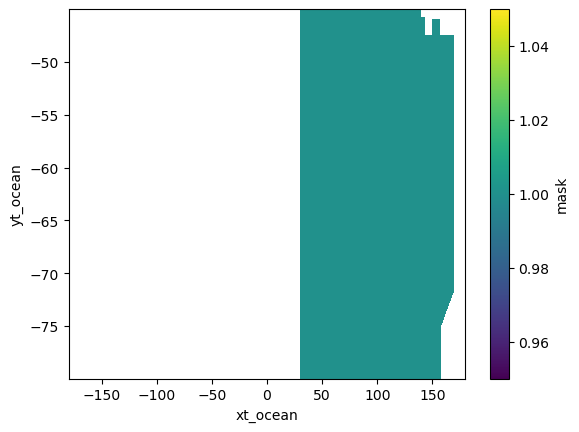

In [24]:
#Subsetting both masks
measo_ind = xr.where((measo >= 13) & (measo <= 19), 1, np.nan)
# measo_ind_v = xr.where((measo_v >= 13) & (measo_v <= 19), 1, np.nan)
#Checking results
measo_ind.plot()

In [7]:
#Full path to static variables
base_dir_static = '/g/data/v45/la6889/Chapter2_Crabeaters/Static_Variables/'

#List of static variables
varDict = {'bottom_slope_deg': 'bathy_slope_GEBCO_2D.nc',
           'dist_shelf_km': 'distance_shelf.nc',
           'dist_coast_km': 'distance_coastline.nc',
           'depth_m': 'bathy_GEBCO_2D.nc'}

## Extracting data for each observation and adding it to a new column in crabeater data

In [12]:
#Looping through dictionary keys
for i, var in enumerate(varDict):
    #Creating full path to file of interest
    file_path = os.path.join(base_dir_static, varDict[var])
    #Load as raster
    ras = xr.open_dataarray(file_path)
    #Apply mask
    ras = ras.where(measo_ind == 1, drop = True)
    #Convert to data frame
    ras = ras.to_series().dropna().reset_index()
    #Round coordinate values
    ras = ras.round({'yt_ocean': 3, 'xt_ocean': 3})
    #Renaming masked data before merging to observations
    ras = ras.rename(columns = {ras.columns[-1]: var})
    #Creating data frame with data
    if i == 0:
        static_vars = ras
    else:
        static_vars = static_vars.merge(ras, on = ['yt_ocean', 'xt_ocean'], how = 'left')
    
#Checking results
static_vars

,yt_ocean,xt_ocean,bottom_slope_deg,dist_shelf_km,dist_coast_km,depth_m
0,-71.478,169.95,89.944382,135.524276,1.609834,206.816666
1,-71.436,169.65,89.972290,139.029088,10.654348,209.966660
2,-71.436,169.75,89.965401,136.600358,7.133048,273.299957
3,-71.436,169.85,89.950462,134.225430,3.646842,282.933319
4,-71.436,169.95,89.920975,131.907215,0.878910,282.933319
...,...,...,...,...,...,...
573542,-45.107,139.55,89.984383,1922.333851,2082.955257,4595.020996
573543,-45.107,139.65,89.985489,1923.484941,2083.891501,4893.250000
573544,-45.107,139.75,89.967529,1924.656796,2084.846193,4900.333496
573545,-45.107,139.85,89.896507,1925.849377,2085.819306,4900.333496


# Saving results

In [13]:
static_vars.to_csv('../Cleaned_Data/Env_obs/All_values_ACCESS-OM2-01_static_vars.csv', index = False)

## Accessing observations

In [49]:
#Creating dictionary with useful information
varDict = {'var_mod': 'dist_km',
           'var_short_name': 'dist_ice_edge_km',
           'obs_base': '/g/data/v45/la6889/Chapter2_Crabeaters/SeaIceObs/Distance_Edge/*.nc',
           #Output folder
           'base_out': '../Cleaned_Data'}
varDict

{'var_mod': 'dist_km',
 'var_short_name': 'dist_ice_edge_km',
 'obs_base': '/g/data/v45/la6889/Chapter2_Crabeaters/SeaIceObs/Distance_Edge/*.nc',
 'base_out': '../Cleaned_Data'}

## Loading data 

In [50]:
#Getting list of all obs in folder
files_var = sorted(glob(varDict['obs_base']))

#Loading all data into single dataset
var_df = xr.open_mfdataset(files_var)
var_df = var_df.rename_vars({varDict['var_mod']: varDict['var_short_name']})
var_df = var_df[varDict['var_short_name']].rename({'lon': 'xt_ocean', 'lat': 'yt_ocean'})

# #Applying Indian sectors mask
var_df = var_df.where(measo_ind == 1, drop = True)

#Checking results
var_df

<xarray.DataArray 'dist_ice_edge_km' (time: 494, yt_ocean: 713, xt_ocean: 1400)>
dask.array<where, shape=(494, 713, 1400), dtype=float64, chunksize=(1, 713, 1400), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) datetime64[ns] 1978-11-15 1978-12-15 ... 2019-12-15
  * yt_ocean  (yt_ocean) float64 -79.97 -79.93 -79.88 ... -45.18 -45.11 -45.04
  * xt_ocean  (xt_ocean) float64 30.05 30.15 30.25 30.35 ... 169.8 169.9 170.0
Attributes:
    units:      km
    long_name:  distance to nearest neighbour

# Calculating mean over time for weaning period
We will include data from 1981 to 2022. The weaning period includes the months of November and December.

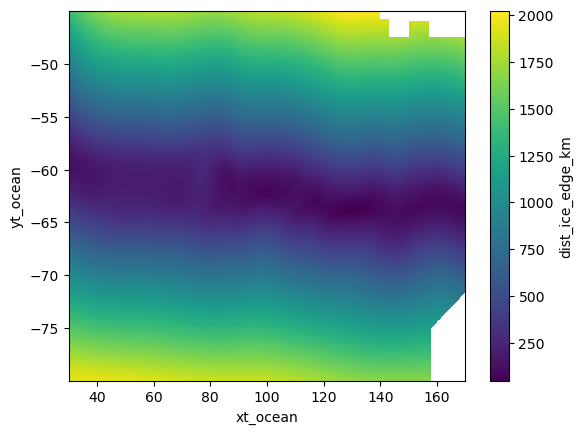

In [51]:
#Identifying timesteps to be included in calculations
mean_var = [da for m, da in var_df.groupby('time.month') if m in [11, 12]]
#Concatenating into single data array and calculate mean over entire time period
mean_var = xr.concat(mean_var, dim = 'time').mean('time')
#Checking results
mean_var.plot()

## Adding mean calculations for dynamic environmental variables to data frame with static environmental data

In [22]:
#Loading file
env_vars = pd.read_csv('../Cleaned_Data/Env_obs/All_values_ACCESS-OM2-01_static_vars.csv')
env_vars

,yt_ocean,xt_ocean,bottom_slope_deg,dist_shelf_km,dist_coast_km,depth_m
0,-71.478,169.95,89.944382,135.524276,1.609834,206.81667
1,-71.436,169.65,89.972290,139.029088,10.654348,209.96666
2,-71.436,169.75,89.965401,136.600358,7.133048,273.29996
3,-71.436,169.85,89.950462,134.225430,3.646842,282.93332
4,-71.436,169.95,89.920975,131.907215,0.878910,282.93332
...,...,...,...,...,...,...
573542,-45.107,139.55,89.984383,1922.333851,2082.955257,4595.02100
573543,-45.107,139.65,89.985489,1923.484941,2083.891501,4893.25000
573544,-45.107,139.75,89.967529,1924.656796,2084.846193,4900.33350
573545,-45.107,139.85,89.896507,1925.849377,2085.819306,4900.33350


In [52]:
#Converting to pandas data frame
var_pd = mean_var.to_series().dropna().reset_index()
#Round coordinate values
var_pd = var_pd.round({'yt_ocean': 3, 'xt_ocean': 3})
#Renaming masked data before merging to observations
var_pd = var_pd.rename(columns = {varDict['var_mod']: varDict['var_short_name']})
#Checking results
var_pd.head()

,yt_ocean,xt_ocean,dist_ice_edge_km
0,-79.968,30.05,1927.171315
1,-79.968,30.15,1927.418966
2,-79.968,30.25,1927.652082
3,-79.968,30.35,1927.887722
4,-79.968,30.45,1928.125887


## Merging all variables together

In [53]:
#Getting column names for merging
cols = var_pd.drop(columns = varDict['var_short_name']).columns.tolist()
#Merging columns
env_vars = env_vars.merge(var_pd, on = cols, how = 'left')

#Checking results
env_vars

,yt_ocean,xt_ocean,bottom_slope_deg,dist_shelf_km,dist_coast_km,depth_m,SIC,SST_degC,lt_pack_ice,dist_ice_edge_km
0,-71.478,169.95,89.944382,135.524276,1.609834,206.81667,NaN,NaN,0.0,762.603573
1,-71.436,169.65,89.972290,139.029088,10.654348,209.96666,NaN,NaN,0.0,761.900553
2,-71.436,169.75,89.965401,136.600358,7.133048,273.29996,NaN,NaN,0.0,760.698900
3,-71.436,169.85,89.950462,134.225430,3.646842,282.93332,NaN,NaN,0.0,759.510610
4,-71.436,169.95,89.920975,131.907215,0.878910,282.93332,NaN,NaN,0.0,758.329538
...,...,...,...,...,...,...,...,...,...,...
573542,-45.107,139.55,89.984383,1922.333851,2082.955257,4595.02100,0.0,11.191411,0.0,2003.212653
573543,-45.107,139.65,89.985489,1923.484941,2083.891501,4893.25000,0.0,11.205198,0.0,2003.268954
573544,-45.107,139.75,89.967529,1924.656796,2084.846193,4900.33350,0.0,11.216744,0.0,2003.299485
573545,-45.107,139.85,89.896507,1925.849377,2085.819306,4900.33350,0.0,11.228247,0.0,2003.318655


## Saving results

In [54]:
env_vars.to_csv('../Cleaned_Data/Env_obs/All_values_ACCESS-OM2-01_env_vars.csv', index = False)